<a href="https://colab.research.google.com/github/Dots11/DavesProjects/blob/master/09_SkimLit_nlp_milestone_project_2_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: Skimlit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

**Resource**: If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-719159ea-1829-12ac-ec7a-8d4bf28c6c46)


## Get data

Since we'll be replicating the paper above (PubMed 200k RT), let's download the dataset they used. 

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess our data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualise, visualise, visualise

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """

  with open(filename, "r") as f: # open 'filename' and save it as 'f' ('r' stands for read)
    return f.readlines()

In [ ]:
data_dir

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...



In [ ]:
"""
[{'line_number': 0,
'target': 'BACKGROUND',
'text': "Emotional eating is associated with overeating and the development of obesity .\n",
'total_lines': 11},
...]
"""
#('...' for the next sentence and so forth)

'\n[{\'line_number\': 0,\n\'target\': \'BACKGROUND\',\n\'text\': "Emotional eating is associated with overeating and the development of obesity .\n",\n\'total_lines\': 11},\n...]\n'

The above adds structure that our text file doesn't have

Let's write a function wehich turn each of our datsets into the above format so we can continue to prepare our data for modelling.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence 
  number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if there is an ID line
      abstract_id = line
      abstract_lines = "" # resets the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines, when recognizing '\n'

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split): # counting each line, and passing a dictionary through each.
        line_data = {} # create an empty dictionary for each line 
        target_text_split = abstract_line.split("\t") # split target label from text--
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and  lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the extract?
        line_data["total_lines"] = len(abstract_line_split) -1 # how many total lines are there in the target abstract (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

      

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line #(if it is not an '###' ID line, or a new space/empty string - the else statement is saying that all the lines between '###' line and 'space (\n)' are part of the same abstract. It is the target line the function is iterating through, and will be added to the abstract lines string. The abstract lines string resets to "" once it encounters an ID line, and continues to the next target extract and so on.)
    
  return abstract_samples
    
    




In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))


180040 30212 30135
CPU times: user 449 ms, sys: 94.1 ms, total: 543 ms
Wall time: 555 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
a_string = "you string here"
word_list = a_string.split()
number_of_words = len(word_list)
print(number_of_words)


3


In [ ]:
# Quick example of how the splitlines function work
txt = "Thank you for the music\nWelcome to the jungle"

x = txt.splitlines()

print(x)


['Thank you for the music', 'Welcome to the jungle']


Now that our data is the format of a list of dictionaries,how about we turn it into a DataFrame to further visualize it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

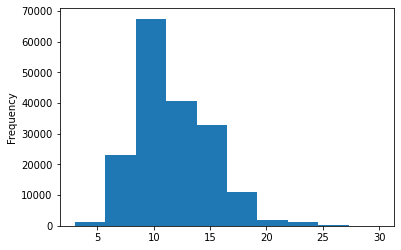

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get a list of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)
Two ways:
* One-hot encode
* Label encode

### One-hot encode labels (text to 0's and 1's)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1)) # can leave as 'transform' (same as previous dataset)
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
# Check what one hot encoded labels look like
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import sklearn
print(sklearn.__version__)

1.0.2


In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels (text to numbers)

In [ ]:
# Extract labels ("target" columns) and encode them into integers (numeric version)
from sklearn.preprocessing import LabelEncoder # very similar to one hot encoding except they'll be integers instead of '0's and '1's
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # text to numbers
from sklearn.naive_bayes import MultinomialNB # modelling with 'Multinomial NB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()) # 'clf' shorthand for classifier
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences, # scikit learn's equivalent to keras's evaluate.
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script
In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-15 12:23:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-15 12:23:02 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to cereate vectorization and embedding layers.

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences] # splits sentences into token level 
avg_sen_len = np.mean(sent_lens)
avg_sen_len


26.338269273494777

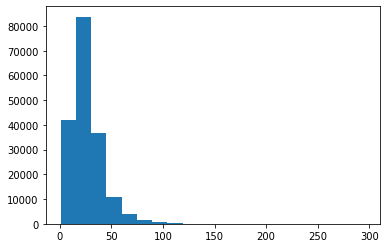

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins= 20);

In [ ]:
# Check the 95% percentile sentence length
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens) # this is why 'x' goes to 300

296

### Create text vectorizer layer
We want to make a layer which maps our text from words to numbers

In [ ]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len) # desired output length of vectorized sequences
                                    # the rest of the parameters we'll leave as default - they work well as they are.

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

# maps individual words with text vectorizer

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")

print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
images were reconstructed with ir and filtered back projection ( fbp ) .

Length of text: 13

Vectorized text: [[1531    9 6056    7 1916    3 5916 1051 6607 5843    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# 65 k here because using the dataset with numbers removed

In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding
Unlike tokenization, embeddings allow us to give us a richer representation of relationships between tokens, which can be learned by our model

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of our vocabulary
                               output_dim = 128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero = True, # use masking to handle variable sequence lengths (save space), when there are many zeroes
                               name = "token_embedding")





In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shown")

Sentence before vectorization:
 images were reconstructed with ir and filtered back projection ( fbp ) .

Sentence after vectorization (before embedding):
 [[1531    9 6056    7 1916    3 5916 1051 6607 5843    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02332642 -0.01516197  0.04540427 ...  0.04465828 -0.03600891
   -0.00977863]
  [-0.03003098  0.03482845 -0.03473352 ...  0.0170739   0.04175023
    0.00090346]
  [ 0.04393407  0.00616767 -0.04110418 ... -0.00667103  0.04231806
   -0.04315014]
  ...
  [ 0.00656365  0.03390357  0.00194035 ...  0.04744388  0.00831257
   -0.01736667]
  [ 0.00656365  0.03390357  0.00194035 ...  0.04744388  0.00831257
   -0.01736667]
  [ 0.00656365  0.03390357  0.00194035 ...  0.04744388  0.00831257
   -0.01736667]]]

Embedded sentence shown


In [ ]:
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Embedded sentence shape: (1, 55, 128)


In [ ]:
# so the above shape: 1 sequence long, 55 tokens long, 128 feature vector long per token in the sentence)

## Creating datesets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the Tensorflow tf.data API, many of the steps here are discussed at length in these two resources:  
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

# takes a list of strings e.g. train_sentences and an array of labels e.g. train_labels_one hot, and combine them together into a "tf.data tensor slice dataset"

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# We see that it returns a 'tuple' consisting of (train_sentences, val_labels_one_hot)/ "((),(5,))" (blank "()" means train_sentences is a shape which varies)

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0] # justifying our label array is 5 long

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorSliceDataset's and turn them in prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # "AUTOTUNE" automatically prefetches as many samples as  you can.
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# And we are not shuffling, as the order of training samples is important for SkimLit, for our model to learn the sequences

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D  with token  embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1,), dtype = tf.string) # layer 1
text_vectors = text_vectorizer(inputs) # vectorize text inputs # layer 2
token_embeddings = token_embed(text_vectors) # create embedding # layer 3
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(token_embeddings) # layer 4.
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer # layer 5.
outputs = layers.Dense(num_classes, activation = "softmax")(x) # layer 6.
model_1 = tf.keras.Model(inputs, outputs)

# Compile our model

model_1.compile(loss = tf.keras.losses.categorical_crossentropy, # we are working with multiple classes e.g. 5 labels
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [ ]:
model_1.summary() # get a summary of our model 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
train_dataset # this is a tuple, a prefetch dataset that will load quite fast thanks to 'AUTOTUNE' 

#It has both the dataset and the label, so no need to pass train sentences and train labels. train_dataset has been formatted to a format that fit can take

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
len(train_dataset) # No. batches we're running on from 20k RCT

5627

In [ ]:
5627 * 32 # think its better to reduce this smaller, so to identify what doesn't work quickly

180064

In [ ]:
valid_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset, # train_sentences or train_labels not required - train_dataset has been formatted to a format that fit can take
                              steps_per_epoch = int(0.1*len(train_dataset)), # we want our model to look at 10% of batches in every epoch (but at the sacrifice of the model not seeing the all the samples of the dataset in every epoch)
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9281 - accuracy: 0.6323 - val_loss: 0.6860 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6560 - accuracy: 0.7593 - val_loss: 0.6273 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6154 - accuracy: 0.7753 - val_loss: 0.5955 - val_accuracy: 0.7849


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5971 - accuracy: 0.7864


[0.5970697402954102, 0.7864424586296082]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.20210898e-01, 1.71682820e-01, 8.68527442e-02, 2.99833328e-01,
         2.14202348e-02],
        [4.00414616e-01, 2.95632154e-01, 1.22815594e-02, 2.81773239e-01,
         9.89839621e-03],
        [1.36883289e-01, 6.25736732e-03, 1.59719691e-03, 8.55219245e-01,
         4.29009633e-05],
        ...,
        [7.37947221e-06, 7.19303498e-04, 8.08593526e-04, 4.39415908e-06,
         9.98460293e-01],
        [4.77128439e-02, 4.06378776e-01, 1.03456825e-01, 6.17950894e-02,
         3.80656421e-01],
        [1.78247839e-01, 7.13025928e-01, 3.13642435e-02, 3.31453159e-02,
         4.42166962e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1) # argmax returns the index with the maximum value
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7836384082324085,
 'recall': 0.7864424731894611,
 'f1': 0.7836780921641452}

## Model 2: Feature extraction with pretrained embeddings

Now let's use pretrained word embeddings from tensorFlow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False, # we're using feature extraction, not a fine-tuning
                                        name = "universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 outcome measures were prevalence of skin damage distinguished in two levels of severity : any skin abnormality/lesion and significant skin lesions .
Sentence after embedding:
[-0.07026688  0.0140687  -0.06010656  0.04768294  0.05777053 -0.05380379
 -0.00595137 -0.03817718  0.06988165  0.02277716  0.08030047 -0.02852536
 -0.01525351  0.0250778  -0.01856387 -0.02212554 -0.07796054  0.00765621
  0.03949025  0.00391741 -0.01298808  0.0540689  -0.0458257   0.04826808
  0.05843696  0.00109381  0.02481526 -0.02700757  0.05599572  0.05885046]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings from Tensorflow Hub

#### ZTM's method

In [ ]:
# Define feature extraction model using TF Hub Layer
inputs = layers.Input(shape=[], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create an embedding of lenght 512
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
# Note: you can add more layers if you want to
outputs = layers.Dense(5, activation = "softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_2_USE_feature_extractor")

#### David's Method

In [ ]:
# Model 2: Create feature extraction model using imported USE

model_2 = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    tf_hub_embedding_layer, # take in sentences and then encode them  into an embedding
    layers.Dense(128, activation="relu"),
    layers.Dense(5, activation="softmax") 
], name = "model_2_USE_feature_extractor")

# Compile the model

In [ ]:
# Compile the model
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)),
                              )

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9186 - accuracy: 0.6486 - val_loss: 0.7966 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7687 - accuracy: 0.7018 - val_loss: 0.7549 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7521 - accuracy: 0.7112 - val_loss: 0.7402 - val_accuracy: 0.7124


### Evaluate our model

In [ ]:
# Evaluate our model_2

model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7423 - accuracy: 0.7139


[0.7423301339149475, 0.7139216065406799]

In [ ]:
# Predictions and probabilities of our feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 10s 10ms/step


(array([[4.2490473e-01, 3.5764918e-01, 1.9428682e-03, 2.0833588e-01,
         7.1672937e-03],
        [3.5401824e-01, 4.6452221e-01, 2.2304603e-03, 1.7696933e-01,
         2.2597136e-03],
        [2.4184957e-01, 1.6469936e-01, 1.7854853e-02, 5.3938460e-01,
         3.6211643e-02],
        ...,
        [1.9331600e-03, 6.1619561e-03, 5.2654032e-02, 9.0393890e-04,
         9.3834686e-01],
        [4.9777110e-03, 4.5105230e-02, 1.7830549e-01, 1.5556940e-03,
         7.7005583e-01],
        [1.8486427e-01, 2.9283944e-01, 4.6787944e-01, 8.3584832e-03,
         4.6058372e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert our model's probabilities to classes (predictions)
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds, model_2_preds.shape

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>,
 TensorShape([30212]))

In [ ]:
# Calculate our model's results 
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.39216205481266,
 'precision': 0.7146003958955321,
 'recall': 0.7139216205481266,
 'f1': 0.7109073439958351}

In [ ]:
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7836384082324085,
 'recall': 0.7864424731894611,
 'f1': 0.7836780921641452}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

In [ ]:
### Create a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make funciton to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'o u t c o m e   m e a s u r e s   w e r e   p r e v a l e n c e   o f   s k i n   d a m a g e   d i s t i n g u i s h e d   i n   t w o   l e v e l s   o f   s e v e r i t y   :   a n y   s k i n   a b n o r m a l i t y / l e s i o n   a n d   s i g n i f i c a n t   s k i n   l e s i o n s   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences] # records the sentence length of each sentence
mean_char_len = np.mean(char_lens)
mean_char_len # average sentence length

149.3662574983337

In [ ]:
len(train_sentences[0])

281

In [ ]:
char_lens[:10]

[281, 137, 111, 65, 209, 147, 161, 164, 180, 51]

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

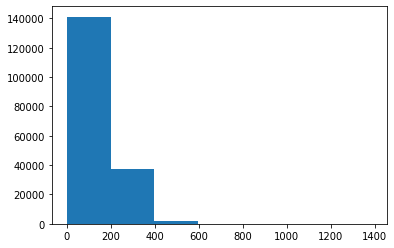

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# So all sentences with words greater than 290 will be truncated to 290, 
# and less than 290 will be capped with '0's until equal to 290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
random.choice(train_sentences)

'neutralization was assessed by plaque reduction neutralization tests ( prnt@ ) against three recent isolates from jev genotypes @ and @ in addition to four jev previously tested .'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab. '[UNK]')
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize = None, # set standardization to "None" if you want to leave punctuation in
                                    standardize = "lower_and_strip_punctuation",
                                    name = "char_vectorizer")


In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars) # 'adapt' sorts by occurance count

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
#print(f"\nLength of random_train_chars: {len(split_chars(random_train_chars))}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 f r e e z e - d r i e d   p o w d e r e d   y a c o n   (   f d y   )   c a n   b e   c o n s i d e r e d   a   p r e b i o t i c   p r o d u c t   d u e   t o   i t s   f r u c t o o l i g o s a c c h a r i d e s   (   f o s   )   c o n t e n t   .

Length of random_train_chars: 105

Vectorized chars:
 [[17  8  2  2 25  2 10  8  4  2 10 14  7 20 10  2  8  2 10 19  5 11  7  6
  17 10 19 11  5  6 22  2 11  7  6  9  4 10  2  8  2 10  5 14  8  2 22  4
   7  3  4 11 14  8  7 10 16 11  3 10 16  2  3  7  4  3  9 17  8 16 11  3
   7  7 12  4 18  7  9  5 11 11 13  5  8  4 10  2  9 17  7  9 11  7  6  3
   2  6  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  

#### Create a character-level embedding layer

In [ ]:
# Create character-level embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), # number of different characters
                              output_dim = 25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf
                              mask_zero = True,
                              name = "char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding:\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 f r e e z e - d r i e d   p o w d e r e d   y a c o n   (   f d y   )   c a n   b e   c o n s i d e r e d   a   p r e b i o t i c   p r o d u c t   d u e   t o   i t s   f r u c t o o l i g o s a c c h a r i d e s   (   f o s   )   c o n t e n t   .

Embedded chars (after vectorization and embedding:
 [[[-0.02622248 -0.02722405 -0.02882218 ...  0.03490986  0.0138674
   -0.00015035]
  [ 0.02473525 -0.04511334 -0.0126549  ...  0.02833198 -0.03723546
   -0.00829605]
  [ 0.04470359  0.02136197  0.02915682 ...  0.04349598  0.04251629
   -0.02885262]
  ...
  [ 0.00884422 -0.03235669 -0.0425895  ... -0.01813858 -0.01607515
    0.02640093]
  [ 0.00884422 -0.03235669 -0.0425895  ... -0.01813858 -0.01607515
    0.02640093]
  [ 0.00884422 -0.03235669 -0.0425895  ... -0.01813858 -0.01607515
    0.02640093]]]

Character embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

249

### Building a Conv1D model to fit on character embeddings

In [ ]:
# Define feature extraction model using TF Hub Layer
inputs = layers.Input(shape=(1,), dtype = tf.string) # shape = (1,) - we are taking one sequence at a time
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors) # tokenize text and create an embedding of lenght 512
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = "relu")(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
# Note: you can add more layers if you want to
outputs = layers.Dense(5, activation = "softmax")(x) # create the output layer
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_3_Conv1D_char_embeddings")

In [ ]:
# Compile our model
model_3.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [ ]:
# Summary of our model
model_3.summary()

Model: "model_3_Conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 

In [ ]:
# Create char level datasets # same with our token embeddings.
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              validation_data = val_char_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              validation_steps = int(0.1*len(val_char_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2609 - accuracy: 0.4895 - val_loss: 1.0243 - val_accuracy: 0.5921
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9888 - accuracy: 0.6048 - val_loss: 0.9228 - val_accuracy: 0.6366
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9192 - accuracy: 0.6332 - val_loss: 0.8596 - val_accuracy: 0.6656


In [ ]:
# Results improved when GlobalAveragePool changed to GlobalMaxPool

In [ ]:
# Make predictions with character model only 
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.16320336, 0.45981225, 0.15916589, 0.1638028 , 0.05401573],
       [0.19797966, 0.4470378 , 0.00436847, 0.341713  , 0.00890114],
       [0.19182716, 0.447143  , 0.09601521, 0.24159765, 0.023417  ],
       ...,
       [0.01267686, 0.02363158, 0.22402412, 0.01991669, 0.71975076],
       [0.13649496, 0.14471644, 0.32395023, 0.10586312, 0.28897527],
       [0.42020836, 0.3844253 , 0.10085306, 0.08698675, 0.00752653]],
      dtype=float32)

In [ ]:
# Convert prediction probabiliites to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 0])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 65.85462730041043,
 'precision': 0.6572601279487916,
 'recall': 0.6585462730041043,
 'f1': 0.6502375964792975}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Try to change parameters to improve model 3 above

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar  `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of 1612.0 (https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character level sequences as input and produces sequence labels probabilities as output

In [ ]:
# 1. Setup token inputs/model (similar to model_1)
# We are using functional API here as it is more flexible than sequential API. See https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/
token_inputs = layers.Input(shape=[], dtype=tf.string, name = "token_input") # our USE expects shape =[]
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings) # paper used 300 for GloVe embedding layer
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Setup char inputs/model (similar to model_3)
char_inputs = layers.Input(shape =(1,), dtype = tf.string, name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-lSTM shown in Fig 1: https://arxiv.org/pdf/1612.05251.pdf # '50' in paper (25 doubles in bi_lstm), though '24' is a multiple of 8, allows speeding up on GPU processing
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding) https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout) # slightly different to Fig 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout) # num_classes = 5

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], # another plus using functional API - you can pass in a list of (multiple) inputs
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

Biggest model we built so far!

In [ ]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

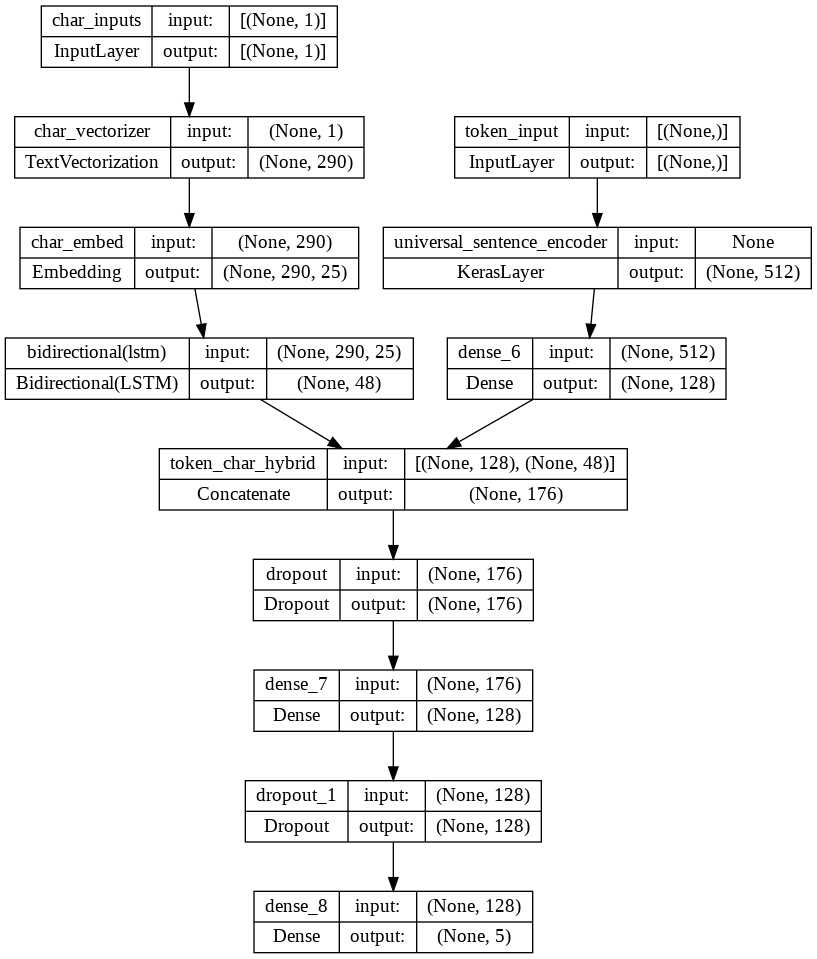

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

Note: 'None' represents batch size '32'

In [ ]:
# Compile token char model
model_4.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(), # section 4.2 of the paper says SGD, you might want to try this
                metrics = ["accuracy"])

## Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data (*Note* ensure order e.g. token-level, char level is the same as the order that our model e.g. model_4 was constructed in)
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels (was with 'train sentences' previously)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #combining the above, as a tuple. More info on 'Dataset.zip' https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTOTUNE uses the best combination of CPU and GPU threads

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels (was with 'val sentences' previously)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combining the above, as a tuple. More info on 'Dataset.zip' https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTOTUNE uses the best combination of CPU and GPU threads

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit our model_4

history_model_4 = model_4.fit(train_char_token_dataset,
                              validation_data = val_char_token_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              validation_steps = int(0.1*len(val_char_token_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 39s 55ms/step - loss: 0.9902 - accuracy: 0.6010 - val_loss: 0.7901 - val_accuracy: 0.6975
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.8050 - accuracy: 0.6882 - val_loss: 0.7178 - val_accuracy: 0.7277
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7735 - accuracy: 0.7021 - val_loss: 0.6872 - val_accuracy: 0.7370


In [ ]:
#Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.6925 - accuracy: 0.7353


[0.6925138235092163, 0.7352707386016846]

In [ ]:
# Get the prediction probabilities of our model_4
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 22ms/step


array([[4.3956587e-01, 3.2560608e-01, 5.3287996e-03, 2.1981597e-01,
        9.6832905e-03],
       [3.6488107e-01, 4.4954792e-01, 3.4883409e-03, 1.7955928e-01,
        2.5234288e-03],
       [2.9413685e-01, 2.2538248e-01, 3.9521243e-02, 3.9437050e-01,
        4.6588901e-02],
       ...,
       [5.9286586e-04, 9.6012400e-03, 7.6347202e-02, 2.3245308e-04,
        9.1322631e-01],
       [4.9111717e-03, 4.4978008e-02, 2.0592241e-01, 2.6469375e-03,
        7.4154150e-01],
       [3.0270535e-01, 3.2280669e-01, 2.8890759e-01, 3.2896239e-02,
        5.2684139e-02]], dtype=float32)

In [ ]:
# Get the predictions of our model 4

model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate our token-char-hybrid model_4's results

model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results


{'accuracy': 73.52707533430424,
 'precision': 0.7337520433772432,
 'recall': 0.7352707533430425,
 'f1': 0.7313063503824436}

In [ ]:
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7836384082324085,
 'recall': 0.7864424731894611,
 'f1': 0.7836780921641452}

In [ ]:
## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

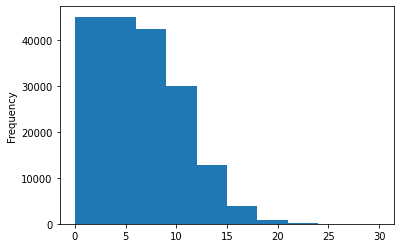

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one_hot_encoded tensors of our "line_number" column (to remove potential discrepancy of our model thinking e.g. line no. 4 is twice the size of line no.2)
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth= 15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape



(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
train_line_numbers_one_hot[0].shape
train_line_numbers_one_hot[0].dtype

tf.float32

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

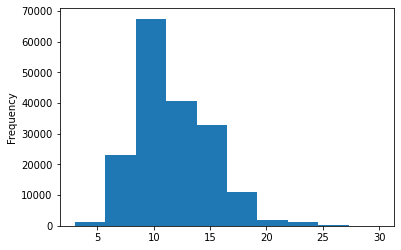

In [ ]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # we would cover 98% of the samples (you could try higher if you wish)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

Positional embeddings are now ready for our model 5

## Model_5 building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate.
6. Combine the outputs of 3,4,5 using tf.keras.layers.concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [ ]:
#Shape of line numbers
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [ ]:
# Shape of total lines
train_total_lines_one_hot[0].shape

TensorShape([20])

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype = tf.string, name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_vectors = char_vectorizer(char_inputs) # turning our characters into integers
char_embeddings = char_embed    (char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # 24 will double to 48
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape =(15,), dtype = tf.float32, name = "line_number_inputs")
x = layers.Dense(32, activation = "relu")(line_number_inputs) # 'x' is common naming convention for layers in between
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_line_inputs")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

#5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embedding")([token_model.output,
                                                                           char_model.output]) # order is important

z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                  z])

#7. Create output layer
output_layer = layers.Dense(5, activation = "softmax", name = 'output_layer')(tribrid_embeddings)

#8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input, 
                         total_lines_model.input, 
                         token_model.input,
                         char_model.input], # it is important to know the order of the inputs here
                         outputs = output_layer,
                         name = "model_5_tribrid_embedding_model")

In [ ]:
# Let's get a summary of our tribrid embedded model 5
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

In [ ]:
model_5.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

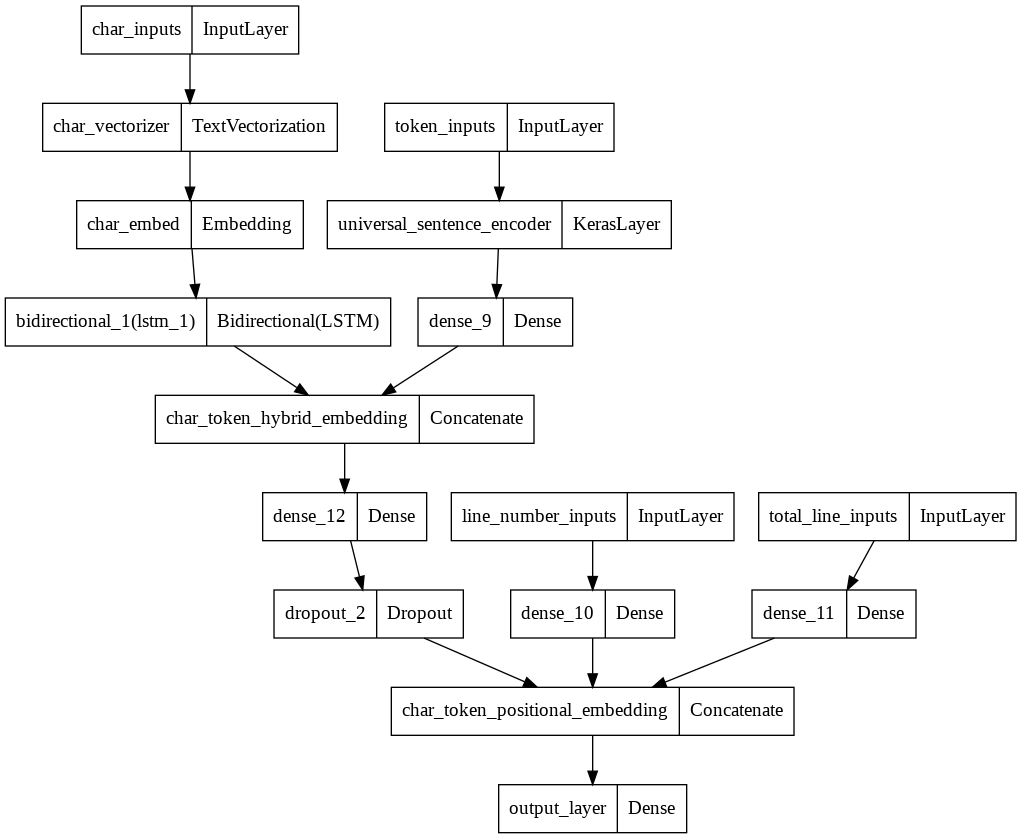

In [ ]:
# Plot model_5 to explore it virtually
from tensorflow.keras.utils import plot_model
plot_model(model_5)


Biggest model we built so far!

Tribrid embedding because it has **1.** Character embeddings, **2.** Token embeddings, and **3.** Feature/ position embeddings

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does it it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> **Resource** For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

### Create tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels (was with 'train sentences' previously)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)) #combining the above, as a tuple. More info on 'Dataset.zip' https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# Prefetch and batch train data
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTOTUNE uses the best combination of CPU and GPU threads


# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars)) # has to be in the same order as the train dataset above
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels (was with 'val sentences' previously)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)) #combining the above, as a tuple. More info on 'Dataset.zip' https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Prefetch and batch val data
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTOTUNE uses the best combination of CPU and GPU threads

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Check out our training char and token embedding dataset
val_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Compile our model
model_5.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

## Fitting, evaluating and making predictions with our tribrid model

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 *len(train_char_token_pos_dataset)),
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 40s 57ms/step - loss: 0.7431 - accuracy: 0.7245 - val_loss: 0.5296 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.4934 - accuracy: 0.8123 - val_loss: 0.4598 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.4578 - accuracy: 0.8229 - val_loss: 0.4426 - val_accuracy: 0.8288


In [ ]:
# Evaluate our model

model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 22s 24ms/step - loss: 0.4419 - accuracy: 0.8291


[0.44193583726882935, 0.8291076421737671]

In [ ]:
# Get the prediction probabilities of our model 5
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 24s 23ms/step


array([[5.80752969e-01, 1.46871628e-02, 4.59220668e-04, 4.03416932e-01,
        6.83648745e-04],
       [6.56438291e-01, 6.69685472e-03, 2.23920052e-03, 3.34587455e-01,
        3.81975733e-05],
       [4.45378870e-01, 1.10805556e-02, 4.02309373e-02, 4.88266170e-01,
        1.50433779e-02],
       ...,
       [2.48563330e-04, 2.77527887e-02, 8.82998947e-03, 1.37895495e-05,
        9.63154852e-01],
       [1.00463571e-03, 2.85385907e-01, 1.38826771e-02, 6.84942279e-05,
        6.99658334e-01],
       [1.63108721e-01, 7.47805953e-01, 6.58653527e-02, 2.23983801e-03,
        2.09800862e-02]], dtype=float32)

In [ ]:
# Get the predictions of our model
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Get the results of our model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 82.91076393486033,
 'precision': 0.8301793781090644,
 'recall': 0.8291076393486032,
 'f1': 0.8291399893891461}

In [ ]:
model_1_results

{'accuracy': 78.64424731894611,
 'precision': 0.7836384082324085,
 'recall': 0.7864424731894611,
 'f1': 0.7836780921641452}

Had trained on 10 % of the data the whole time (PubMed 20k dataset) - what a result!

## Compare model results

In [ ]:
# Combine model resutls into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                  "model_1_custom_token_embedding" : model_1_results,
                                  "model_2_pretrained_token_embedding" : model_2_results,
                                  "model_3_custom_char_embedding" : model_3_results,
                                  "model_4_hybrid_char_token_embedding" : model_4_results,
                                  "model_5_pos_char_token_embedding" : model_5_results})

all_model_results = all_model_results.transpose() # flips axis, displays models and their results column by column
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.644247,0.783638,0.786442,0.783678
model_2_pretrained_token_embedding,71.392162,0.714600,0.713922,0.710907
model_3_custom_char_embedding,65.854627,0.657260,0.658546,0.650238
model_4_hybrid_char_token_embedding,73.527075,0.733752,0.735271,0.731306
model_5_pos_char_token_embedding,82.910764,0.830179,0.829108,0.829140


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


In [ ]:
all_model_results # accuracy now same format as others

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.786442,0.783638,0.786442,0.783678
model_2_pretrained_token_embedding,0.713922,0.714600,0.713922,0.710907
model_3_custom_char_embedding,0.658546,0.657260,0.658546,0.650238
model_4_hybrid_char_token_embedding,0.735271,0.733752,0.735271,0.731306
model_5_pos_char_token_embedding,0.829108,0.830179,0.829108,0.829140


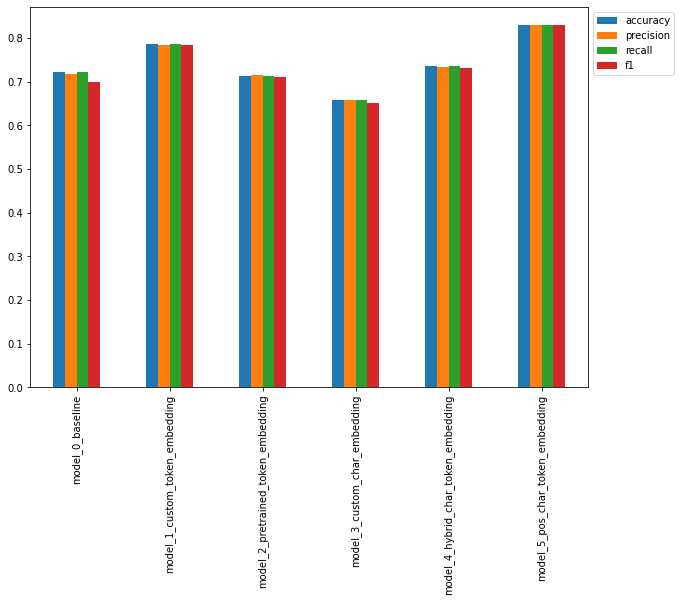

In [ ]:
# Let's plot and compare all model results;
all_model_results.plot(kind="bar", figsize = (10, 7)).legend(bbox_to_anchor=(1.0, 1.0)) # bounding box = allows us our legend to be at the side of bar graph

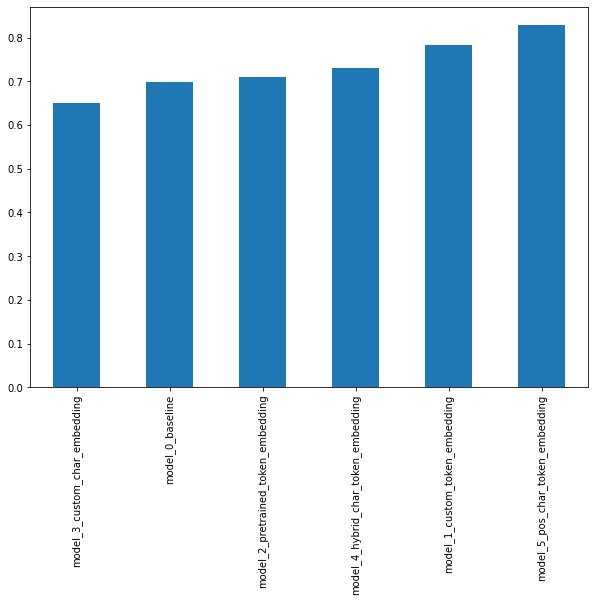

In [ ]:
# Sort the models results by f1-scores
all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind="bar", figsize=(10,7))

What if combining the best of model_1 and model_5? Give it a try!

In [ ]:
## Save the best performing model
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions witht he loaded model on the validation dataset
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_preds[:10]

945/945 [==============================] - 30s 28ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate results of our loaded_model (and see if matches model_5)
loaded_model_5_results = calculate_results(y_true = val_labels_encoded,
                                           y_pred = loaded_preds)
loaded_model_5_results

{'accuracy': 82.91076393486033,
 'precision': 0.8301793781090644,
 'recall': 0.8291076393486032,
 'f1': 0.8291399893891461}

In [ ]:
model_5_results

{'accuracy': 82.91076393486033,
 'precision': 0.8301793781090644,
 'recall': 0.8291076393486032,
 'f1': 0.8291399893891461}

In [ ]:
assert model_5_results == loaded_model_5_results # return error message if not equal

In [ ]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

Keep in mind: To save these results (apart from retrain/reload and saving), copy onto google drive or save onto your machine

## Your challenge
1. Make example predictions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.